# Experimenting with Multivariate LSTM and indices...

I'm reading a datafile with all the REPSOL indices that we were computing using the 9th floor Spark processes. We will try to predict if the vlaue will go 'Up' or 'Down'.

In [19]:
import numpy
import math

import matplotlib.pyplot as plt
from pandas import read_csv, concat, DataFrame
from matplotlib import pyplot
from numpy import concatenate

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Read the input dataset

    Input <-  Path
    Output -> raw_dataset

In [20]:
def read_dataset(file_path):
    columNames = ['Price','Up or Down','Volume','High','Low','EMA(Price)',
                  'Typical','RMF(in M)','MFR','MFR Index','PVI','EMA(PVI)','NVI','EMA(NVI)',
                  'OSCP','RMF','MFI','Bollinger Up','Bollinger Down','bollOsc',
                  'gainLoss','RSI','Stochastic Osc']
    
    raw_dataset = read_csv(file_path, header='infer', delimiter=';', usecols=columNames)
    # Remove the first column as it contains the value we want to predict
    # dataset = raw_dataset.iloc[:, 1:]   
    return(raw_dataset)

### Plot each separate signal (indice)

Uncomment to see 23 nice plots!

In [21]:
# values = raw_dataset.values
# # specify columns to plot
# groups = [0,2,3,4,5, 6,7,8,9,10, 11,12,13,14,15, 16,17,18,19,20]
# i = 1
# # plot each column
# pyplot.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# num_rows = int(len(groups)/2)
# num_cols = int(len(groups)/5)
# for group in groups:
#     pyplot.subplot(num_rows, num_cols, i)
#     pyplot.plot(values[:, group])
#     pyplot.title(raw_dataset.columns[group], y=0.75, loc='left', fontsize=7)
#     i += 1
# pyplot.tight_layout()
# pyplot.show()

### Series-To_Supervised

This function is KEY as it produces the array shaped with t-n look-back samples to feed the LSTM

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Scale > Reframe > Drop

Let's make things reproducible. We also convert anything that might not be a float to `float32`. Data in NN is normalized to produce equivalent responses in the different layers. We also do that in this chunk. Then, data is scaled to the range 0..1, reframed according to the syntax in `series-to-supervised` and finally, unuseful columns are removed.

In [23]:
def scale_reframe_drop(raw_dataset):
    # Data types conversion
    dataset = raw_dataset.astype('float32')

    # Scale
    # scaled = scaler.fit_transform(dataset)

    # Reframe
    # reframed = series_to_supervised(scaled, look_back, look_forward)
    reframed = series_to_supervised(dataset, look_back, look_forward)

    # Drop 'num_features - 1' from the tail of each row, as I only want to keep the first one, 
    # which will be what I want to predict.
    num_features = int(reframed.shape[1] / (look_back + 1))
    num_cols = reframed.shape[1]
    cols_to_remove = [reframed.columns[col_idx] for col_idx in range(num_cols - num_features + 1, num_cols)]
    prepared_dataset = reframed.drop(cols_to_remove, axis=1)
    
    # Scale
    scaled = scaler.fit_transform(prepared_dataset)
    df = DataFrame(data=scaled[:,:], index=range(0,scaled.shape[0]), 
               columns=['var-{:d}'.format(i) for i in range(scaled.shape[1])])

    #return prepared_dataset
    return df

### Training & Test

Split and reshape the dataset.

In [24]:
def split_train_test(prepared_dataset):
    # split into train and test sets
    values = prepared_dataset.values
    train_size = int(len(values) * training_set_proportion)
    train = values[0:train_size, :]
    test = values[train_size:, :]
    # print(len(train), len(test))
    # Split into input and output.
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # print('Training shapes.....: X=',train_X.shape, ', y=',train_y.shape, sep='')
    # print('Test shapes.........: X=',test_X.shape, ', y=',test_y.shape, sep='')
    
    # reshape input to be [samples, time steps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    # print('Training reshaped to: X=', train_X.shape, ', y=', train_y.shape, sep='')
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1])) 
    # print('Test reshaped to....: X=', test_X.shape,  ', y=', test_y.shape, sep='')
    return (train_X, train_y, test_X, test_y)

## Train the LSTM !
Define the LSTM parameters, and train it.

In [25]:
def train_model(train_X, train_y, test_X, test_y):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=1, validation_data=(test_X, test_y), 
                        verbose=keras_verbose_level, shuffle=False)
    return model, history

def plot_model_training(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()    

### Compute the error

Compute the error (RMSE) for training and test. Previously, the examples suggest to invert the results from prediction to use the same units than in the source data.

In [79]:
def invert_Y(test_X, Y):
    """
    Invert the Y vector. The way invert works requires to have a matrix with all
    the features in place. That's why I must concatenate the test_X, so that it
    can perform the matrix multiplication. To get only the Y, a column selection
    is done as a final step.
    """
    # Check if this Y vector is special (m,) and is not shaped correctly (m,1)
    if len(Y.shape) is 1:
        Y = Y.reshape((len(Y), 1))
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling the prediction to the original values, for forecast
    inv_Y = concatenate((Y, test_X_reshaped[:, 0:]), axis=1)
    inv_Y = scaler.inverse_transform(inv_Y)
    return inv_Y[:,0]


def predict(model, test_X, invert=True):
    """
    Make a prediction with the model over the test_X dataset as input.
    """ 
    yhat = model.predict(test_X)
    if invert is False:
        return yhat

    inv_yhat = invert_Y(test_X, yhat)
    return inv_yhat
    
    
def compute_error(inv_y, inv_yhat):
    """
    Compute the RMSE between the prediction and the actual values.
    """    
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    return rmse


def compute_cummulative_tendency_error(Y, Yhat):
    """
    Compute the error in tendency (sign of future value minus present value) when making a prediction.
    """
    num_errors = 0
    for idx in range(1, len(Y)):
        yhat_trend = numpy.sign(Yhat[idx]-Yhat[idx-1])
        y_trend = numpy.sign(Y[idx]-Y[idx-1])
        error = int(yhat_trend == y_trend)
        if error == 0:
            num_errors += 1
    return num_errors

### Plot actual values and predicted values.

Plot the whoel series, and the predicted values for the test set.

In [80]:
def plot_prediction(raw_dataset, train_X, inv_y, inv_yhat):
    # Invert original training set to original values for plotting.
    train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    add_col = train_X_reshaped[:,0]
    add_col = add_col.reshape((add_col.shape[0], 1))
    train_X_reshaped = concatenate((train_X_reshaped, add_col), axis=1)
    inv_trainX = scaler.inverse_transform(train_X_reshaped)[:, :-1]
    
    # Plot
    plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.ylim((17.5,20))
    plt.xlim((205,235))
    original_values = raw_dataset.values[:, 0]
    
    train_values = numpy.empty_like(original_values)
    train_values[:] = numpy.nan
    train_values[0:len(inv_trainX)] = inv_trainX[:, 0]
    
    test_values = numpy.empty_like(original_values)
    test_values[:] = numpy.nan
    test_values[-(len(inv_y)):] = inv_y
    
    predicted_values = numpy.empty_like(original_values)
    predicted_values[:] = numpy.nan
    predicted_values[-(len(inv_yhat)):] = inv_yhat
    
    #pyplot.plot(original_values)
    actual_plot = plt.plot(train_values)
    test_plot = plt.plot(test_values, marker='o')
    plt.setp(test_plot, color='g', linewidth=3.0)
    prediction_plot = plt.plot(predicted_values, marker='o')
    
    plt.setp(prediction_plot, color='r', linewidth=1.0)
    plt.show()

### Parameters

Set here all the pipeline parameters and the main pipeline function.

In [81]:
num_epochs = 25
look_back = 1
look_forward = 1
training_set_proportion = 0.9
neurons = 46
numpy.random.seed(2)
file_path = '~/Documents/SideProjects/X/indices_calculados_sinfecha.csv'
scaler = MinMaxScaler(feature_range=(0, 1))
keras_verbose_level = 0

def run_pipeline():
    # read data
    raw_dataset = read_dataset(file_path)
    # prepare it to fit the lstm input
    prepared_dataset = scale_reframe_drop(raw_dataset)
    # split dataset intraining and test
    train_X, train_y, test_X, test_y = split_train_test(prepared_dataset)
    # Train the model
    model, history = train_model(train_X, train_y, test_X, test_y)
    # Make a prediction with the model
    inv_yhat = predict(model, test_X, invert=True)
    # invert scaling the actual test set, for actual values and compare results.
    inv_y = invert_Y(test_X, test_y)
    # Compute the RMSE
    rmse = compute_error(inv_y, inv_yhat)
    num_errs = compute_cummulative_tendency_error(inv_y, inv_yhat)
    print(' neurons | epochs | look_back | RMSE  | Trnd.E')
    print('---------|--------|-----------|-------|--------')
    print(' {:7d} | {:6d} | {:9d} | {:.03f} | {:02d}'.format(neurons, num_epochs, look_back, rmse, num_errs))
    plot_prediction(raw_dataset, train_X, inv_y, inv_yhat)

 neurons | epochs | look_back | RMSE  | Trnd.E
---------|--------|-----------|-------|--------
      46 |     25 |         1 | 0.168 | 05


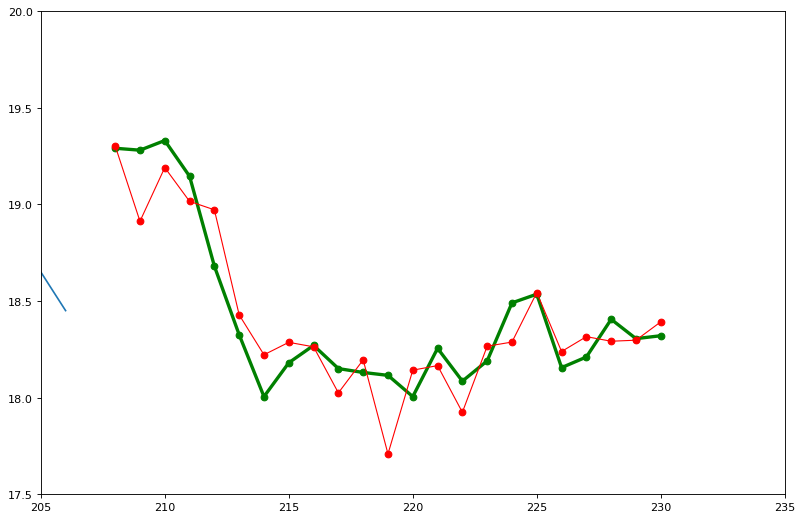

In [82]:
# Run with the best results got below.
run_pipeline()

# TESTING

The results obtained were:

     neurons | epochs | look_back | RMSE
    ---------|--------|-----------|-------
          46 |     25 |         1 | 0.169
          46 |     25 |         2 | 0.189
          46 |     50 |         1 | 0.170
          46 |     50 |         2 | 0.178
          46 |     75 |         1 | 0.165
          46 |     75 |         2 | 0.289
          46 |    100 |         1 | 0.301
          46 |    100 |         2 | 0.346
          92 |     25 |         1 | 0.176
          92 |     25 |         2 | 0.221
          92 |     50 |         1 | 0.163
          92 |     50 |         2 | 0.180
          92 |     75 |         1 | 0.235
          92 |     75 |         2 | 0.174
          92 |    100 |         1 | 0.264
          92 |    100 |         2 | 0.245
          

In [31]:
# print(' neurons | epochs | look_back | RMSE')
# print('---------|--------|-----------|-------')
# for neurons in [46,92]:
#     for num_epochs in [25, 50, 75, 100]:
#         for look_back in [1, 2]:
#             run_pipeline()